<a href="https://colab.research.google.com/github/arvchak/MLProj/blob/main/protonetwork_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install tensorflow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import glob
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import pathlib
from PIL import Image
from numpy.linalg import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/tensorflow_datasets.zip

Streaming output truncated to the last 5000 lines.
  inflating: tensorflow_datasets/RESISC45/downloads/manual/dense_residential/dense_residential_148.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/manual/dense_residential/dense_residential_160.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/manual/dense_residential/dense_residential_606.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/manual/dense_residential/dense_residential_612.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/manual/dense_residential/dense_residential_174.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/manual/dense_residential/dense_residential_613.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/manual/dense_residential/dense_residential_175.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/manual/dense_residential/dense_residential_161.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/manual/dense_residential/dense_residential_607.jpg  
  in

In [5]:
root_path = '/content/tensorflow_datasets/RESISC45/downloads/manual'
output = '/content/tensorflow_datasets/RESISC45/downloads/split_folder'

In [6]:
data_dir = pathlib.Path(root_path)
count =  len(list(data_dir.glob('*/*.jpg')))
print(count)

31500


In [7]:
!pip install split-folders
import splitfolders
splitfolders.ratio(root_path , output , seed = 42 , ratio = (.7, .2 ,.1), group_prefix = None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 31500 files [00:05, 5630.66 files/s]


In [8]:
data_dir_train = pathlib.Path(output+'/train')
data_dir_test = pathlib.Path(output+'/test')
data_dir_val = pathlib.Path(output+'/val')

In [9]:
batch_size = 45
img_height = 224
img_width = 224
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    image_size = (img_height, img_width), 
    batch_size = (batch_size))

Found 22005 files belonging to 45 classes.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_val, 
    image_size = (img_height, img_width), 
    batch_size = (batch_size))

Found 6300 files belonging to 45 classes.


In [11]:
class_names = train_ds.class_names
print(class_names)
no_of_classes = len(class_names)
#train_np = np.stack(list(train_ds))

['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway', 'railway_station', 'rectangular_farmland', 'river', 'roundabout', 'runway', 'sea_ice', 'ship', 'snowberg', 'sparse_residential', 'stadium', 'storage_tank', 'tennis_court', 'terrace', 'thermal_power_station', 'wetland']


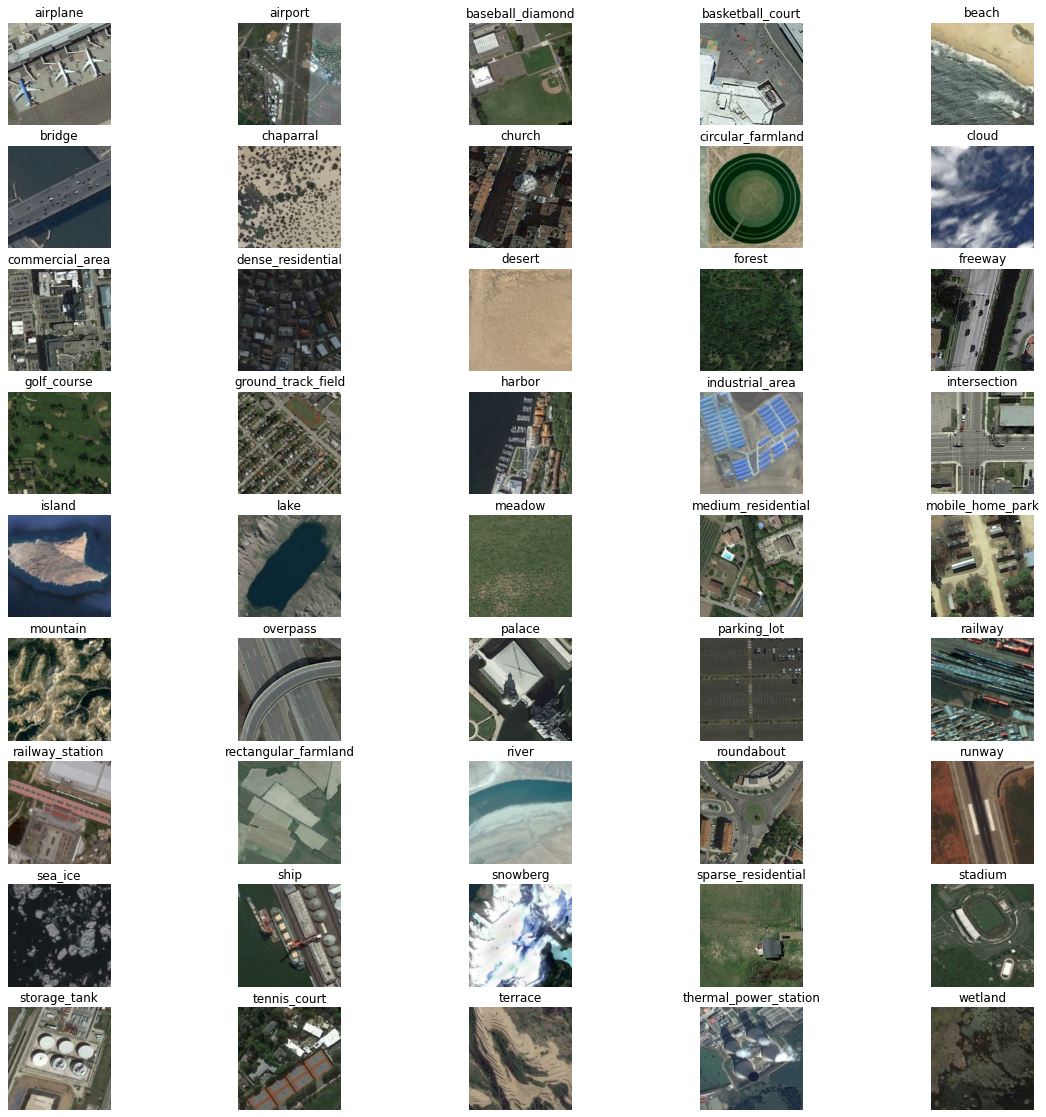

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(9, 5, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

In [13]:
#train_dataset = np.zeros([no_of_classes, 3, img_height, img_width], dtype=object)
examples = np.zeros([no_of_classes, 489, img_height, img_width,3], dtype=np.float32)

for class_name in train_ds.class_names:
    img_files = sorted(glob.glob(os.path.join(data_dir_train , class_name, '*.jpg')))
    
    
    for index, img_file in enumerate(img_files):
        values = 1. - np.array(Image.open(img_file).resize((img_width, img_height)), np.float32, copy=False)
        examples[label, index] = values
        

In [14]:
examples /= 255.0

In [15]:
test_data = np.zeros([no_of_classes, 489, img_height, img_width,3], dtype=np.float32)

for class_name in val_ds.class_names:
    img_files = sorted(glob.glob(os.path.join(data_dir_val , class_name, '*.jpg')))
    for index, img_file in enumerate(img_files):
        values = 1. - np.array(Image.open(img_file).resize((img_width, img_height)), np.float32, copy=False)
        test_data[label, index] = values
        

In [16]:
test_data /= 255.0

In [17]:
examples.shape    

(45, 489, 224, 224, 3)

In [18]:
tf.compat.v1.disable_eager_execution()

In [19]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


In [20]:
def build_model(inputs):
    layer_inputs = layers.Input(tensor = inputs)
    #x = img_augmentation(inputs)
    x = img_augmentation(layer_inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    # Rebuild top
    x = layers.BatchNormalization(epsilon = 0.000010, scale=True, center=True)(x)
    x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x = layers.Flatten()(x)
    return x

In [21]:
def cnn(inputs, op_channels):
    conv = tf.compat.v1.layers.conv2d(inputs, op_channels, kernel_size=3, padding='SAME')
    conv = tf.compat.v1.layers.batch_normalization(conv,scale=True, center=True)
    conv = tf.nn.relu(conv)
    conv = tf.compat.v1.layers.max_pooling2d(conv, strides = 2, pool_size=2)
    return conv

In [22]:
def feature_embeddings(support_set , h_dim , z_dim):
    net = cnn(support_set, h_dim)
    net = cnn(net, h_dim)
    net = cnn(net, h_dim) 
    net = cnn(net, z_dim) 
    net = tf.keras.layers.Flatten()(net)
    return net

In [23]:
#number of classes
num_way = 8

#number of examples per class for support set
num_shot = 5

#number of query points
num_query = 5

#number of examples
num_examples = 50

channel = 3

h_dim = 64

z_dim = 64

In [24]:
support_set = tf.compat.v1.placeholder(tf.float32, [None, None, img_height, img_width, 3])
query_set = tf.compat.v1.placeholder(tf.float32, [None, None, img_height, img_width, 3])
label = tf.compat.v1.placeholder(tf.int64, [None, None])

In [25]:
support_set_shape = tf.shape(support_set)
query_set_shape = tf.shape(query_set)


In [26]:
num_classes, num_support_points = support_set_shape[0], support_set_shape[1]


In [27]:
num_query_points = query_set_shape[1]

In [28]:
y = tf.compat.v1.placeholder(tf.int64, [None, None])

#convert the label to one hot
y_one_hot = tf.one_hot(y, depth=num_classes)
print(y_one_hot.shape)


label_prime = tf.one_hot(label , depth = num_classes)

(None, None, None)


In [29]:
support_set_embeddings = feature_embeddings(tf.reshape(support_set, [num_classes * num_support_points, img_height, img_width, channel]), h_dim, z_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.appl

In [30]:
embedding_dimension = tf.shape(support_set_embeddings)[-1]
class_prototype = tf.reduce_mean(tf.reshape(support_set_embeddings, [num_classes, num_support_points, embedding_dimension]), axis=1)

In [31]:
query_set_embeddings = feature_embeddings(tf.reshape(query_set, [num_classes * num_query_points, img_height, img_width, channel]), h_dim, z_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.appl

In [32]:
def euclidean_distance(a, b):

    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)
   
    

In [33]:
def cosine_similarity(a, b):
    target_normed = a
    sup_similarity = []
    i_normed = tf.nn.l2_normalize(b, 1) 
    similarity = tf.matmul(tf.expand_dims(target_normed, 1), tf.expand_dims(i_normed, 2))
    sup_similarity.append(similarity)
    return tf.squeeze(tf.stack(sup_similarity, axis=1)) 
    
        

In [34]:
print(query_set_embeddings.shape)
print(class_prototype.shape)

distance = euclidean_distance(query_set_embeddings,class_prototype)
print(distance)

predicted_probability = tf.reshape(tf.nn.log_softmax(-distance), [num_classes, num_query_points, -1])
ce = tf.keras.losses.CategoricalCrossentropy()
loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_one_hot, predicted_probability), axis=-1), [-1]))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predicted_probability, axis=-1), y), tf.float32))

train = tf.compat.v1.train.AdamOptimizer().minimize(loss)


(None, 12544)
(None, 12544)
Tensor("Mean_1:0", shape=(None, None), dtype=float32)


In [35]:
sess = tf.compat.v1.InteractiveSession()
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()
sess.run(init)

In [36]:
num_epochs = 20
num_episodes = 100

In [37]:
for epoch in range(num_epochs):
    
    for episode in range(num_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(no_of_classes)[:num_way]
        
        support = np.zeros([num_way, num_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([num_way, num_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:num_shot + num_query]
            support[index] = examples[class_, selected[:num_shot]]
            
            # 5 querypoints per classs
            query[index] = examples[class_, selected[num_shot:]]
            
        #support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(num_way)[:, np.newaxis], (1, num_query)).astype(np.uint8)
        _, loss_, accuracy_ = sess.run([train, loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        
        if (episode+1) % 10 == 0:
            print('Epoch {} : Episode {} : Loss: {}, Accuracy: {}'.format(epoch+1, episode+1, loss_, accuracy_))

Epoch 1 : Episode 10 : Loss: 1.7727292776107788, Accuracy: 0.2750000059604645
Epoch 1 : Episode 20 : Loss: 1.417595624923706, Accuracy: 0.22499999403953552
Epoch 1 : Episode 30 : Loss: 1.4486134052276611, Accuracy: 0.25
Epoch 1 : Episode 40 : Loss: 1.5109670162200928, Accuracy: 0.25
Epoch 1 : Episode 50 : Loss: 1.7303688526153564, Accuracy: 0.2750000059604645
Epoch 1 : Episode 60 : Loss: 1.7289752960205078, Accuracy: 0.25
Epoch 1 : Episode 70 : Loss: 1.434234380722046, Accuracy: 0.25
Epoch 1 : Episode 80 : Loss: 1.3962980508804321, Accuracy: 0.2750000059604645
Epoch 1 : Episode 90 : Loss: 1.5207655429840088, Accuracy: 0.30000001192092896
Epoch 1 : Episode 100 : Loss: 1.4037320613861084, Accuracy: 0.17499999701976776
Epoch 2 : Episode 10 : Loss: 1.4328027963638306, Accuracy: 0.20000000298023224
Epoch 2 : Episode 20 : Loss: 1.420657753944397, Accuracy: 0.25
Epoch 2 : Episode 30 : Loss: 1.384260892868042, Accuracy: 0.25
Epoch 2 : Episode 40 : Loss: 1.521138310432434, Accuracy: 0.224999994

In [38]:

n_test_episodes = 200
n_test_way = 5
n_test_shot = 5
n_test_query = 15


In [39]:
for test_episode in range(n_test_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(no_of_classes)[:n_test_way]
        
        support = np.zeros([n_test_way, n_test_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([n_test_way, n_test_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:n_test_shot + n_test_query]
            support[index] = test_data[class_, selected[:n_test_shot]]
            
            # 5 querypoints per classs
            query[index] = test_data[class_, selected[n_test_shot:]]
            
        #support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
        ls, ac = sess.run([loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        
        if (test_episode+1) % 10 == 0:
            print('Episode {} : Loss: {}, Accuracy: {}'.format(test_episode+1, ls, ac))

Episode 10 : Loss: 1.1090354919433594, Accuracy: 0.4000000059604645
Episode 20 : Loss: 1.1142228841781616, Accuracy: 0.3866666555404663
Episode 30 : Loss: 1.0920406579971313, Accuracy: 0.4399999976158142
Episode 40 : Loss: 0.9532818794250488, Accuracy: 0.3733333349227905
Episode 50 : Loss: 1.6084575653076172, Accuracy: 0.20000000298023224
Episode 60 : Loss: 0.9367826581001282, Accuracy: 0.4266666769981384
Episode 70 : Loss: 0.9350361227989197, Accuracy: 0.46666666865348816
Episode 80 : Loss: 0.9296543598175049, Accuracy: 0.41333332657814026
Episode 90 : Loss: 1.1236201524734497, Accuracy: 0.4399999976158142
Episode 100 : Loss: 1.0925172567367554, Accuracy: 0.41333332657814026
Episode 110 : Loss: 0.9177119135856628, Accuracy: 0.4266666769981384
Episode 120 : Loss: 0.9401534795761108, Accuracy: 0.3866666555404663
Episode 130 : Loss: 0.936616837978363, Accuracy: 0.4399999976158142
Episode 140 : Loss: 0.9427787065505981, Accuracy: 0.36000001430511475
Episode 150 : Loss: 0.9535824656486511,

In [40]:
sess.close()